In [30]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=10, p=0.2),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

# Для валидации/теста (только resize + norm)
val_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

class CsvImageDataset(Dataset):
    def __init__(self, csv_path, split, transform=None, class_names=None):
        df = pd.read_csv(csv_path)
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform

        if class_names is None:
            self.class_names = sorted(self.df['class_name'].unique())
        else:
            self.class_names = class_names

        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = np.array(Image.open(row['image_path']).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)['image']
        label = self.class_to_idx[row['class_name']]
        return image, label

In [31]:
import matplotlib.pyplot as plt

train_losses = []
val_accuracies = []
val_f1s = []
gzsl_seen_accs = []
gzsl_unseen_accs = []
gzsl_hmeans = []


def compute_gzsl(trues_cls, preds_cls, seen_classes, unseen_classes):
    seen_mask = [cls in seen_classes for cls in trues_cls]
    unseen_mask = [cls in unseen_classes for cls in trues_cls]
    seen_acc = sum([t == p for t, p, m in zip(
        trues_cls, preds_cls, seen_mask) if m]) / max(sum(seen_mask), 1)
    unseen_acc = sum([t == p for t, p, m in zip(trues_cls, preds_cls, unseen_mask) if m]) / max(sum(unseen_mask), 1)
    h_mean = 2 * seen_acc * unseen_acc / (seen_acc + unseen_acc) if (seen_acc + unseen_acc) > 0 else 0.0
    return seen_acc, unseen_acc, h_mean

In [32]:
import torch
import open_clip
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# === Конфиги ===
CSV_PATH = 'merged_dataset_v2.csv'
BATCH_SIZE = 128
NUM_WORKERS = 0
NUM_EPOCHS = 30
LR = 1e-6
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'ViT-B-32'
PRETRAINED = 'laion2b_s34b_b79k'
CHECKPOINT_PATH = 'finetuned_openclip_v3'
WEIGHT_DECAY = 1e-2
SPLITS = ['train', 'val', 'test', 'обучение', 'валидация', 'тест']  # можно адаптировать под свой CSV

In [33]:
def get_logits_and_labels(val_loader, model, text_features):
    model.eval()
    all_logits, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Валидация (logits cache)'):
            images = images.to(DEVICE)
            image_features = model.encode_image(images)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            logits = 100. * image_features @ text_features.T
            all_logits.append(logits.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_logits = np.concatenate(all_logits, axis=0)    # [N, num_classes]
    all_labels = np.concatenate(all_labels, axis=0)    # [N]
    return all_logits, all_labels


def grid_search_bias(all_logits, all_labels, all_classes, idx_to_class, seen_classes, unseen_classes):
    is_seen = np.array([c in seen_classes for c in all_classes])
    best_hmean, best_bias = 0, 0
    best_metrics = None
    best_preds = None

    for calib_bias in np.arange(0.0, 2.05, 0.05):
        logits_biased = all_logits - (is_seen * calib_bias)[None, :]
        preds = logits_biased.argmax(axis=1)
        # Индексы -> имена классов
        trues_cls = [idx_to_class[i] for i in all_labels]
        preds_cls = [idx_to_class[i] for i in preds]
        seen_acc, unseen_acc, h_mean = compute_gzsl(trues_cls, preds_cls, seen_classes, unseen_classes)
        if h_mean > best_hmean:
            best_hmean, best_bias = h_mean, calib_bias
            best_metrics = (seen_acc, unseen_acc, h_mean)
            best_preds = preds
        print(f"bias={calib_bias:.2f} | seen: {seen_acc:.4f} | unseen: {unseen_acc:.4f} | H: {h_mean:.4f}")

    print(f"\n[Grid search] Best bias: {best_bias:.2f}, H-mean: {best_hmean:.4f}, seen: {best_metrics[0]:.4f}, unseen: {best_metrics[1]:.4f}")
    return best_bias, best_metrics, best_preds, all_labels


from sklearn.metrics import accuracy_score, f1_score

def evaluate_and_bias(val_loader, model, text_features, all_classes, idx_to_class, seen_classes, unseen_classes):
    all_logits, all_labels = get_logits_and_labels(val_loader, model, text_features)
    best_bias, (seen_acc, unseen_acc, h_mean), best_preds, best_trues = grid_search_bias(
        all_logits, all_labels, all_classes, idx_to_class, seen_classes, unseen_classes
    )
    acc = accuracy_score(best_trues, best_preds)
    macro_f1 = f1_score(best_trues, best_preds, average='macro')
    print(f"[BIASED VAL] bias={best_bias:.2f} | Seen acc: {seen_acc:.4f} | Unseen acc: {unseen_acc:.4f} | H-mean: {h_mean:.4f}")
    print(f"[Валидация] Top-1 Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")
    return best_bias, seen_acc, unseen_acc, h_mean, acc, macro_f1

In [34]:
df = pd.read_csv(CSV_PATH)
all_classes = sorted(df['class_name'].unique().tolist())

# --- Датасеты ---
train_dataset = CsvImageDataset(CSV_PATH, split='train', transform=train_transform, class_names=all_classes)
val_dataset   = CsvImageDataset(CSV_PATH, split='val',   transform=val_transform, class_names=all_classes)

train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader    = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

idx_to_class = {i: c for i, c in enumerate(all_classes)}
class_to_idx = {c: i for i, c in enumerate(all_classes)}

# --- Seen/Unseen классы ---
train_classes = set(df[df['split'] == 'train']['class_name'].unique())
val_classes = set(df[df['split'] == 'val']['class_name'].unique())
unseen_classes = val_classes - train_classes
seen_classes = train_classes & val_classes

# --- Текстовые эмбеддинги для всех классов ---
tokenizer = open_clip.get_tokenizer(MODEL_NAME)
prompts = [f"{c}" for c in all_classes]
text_tokens = tokenizer(prompts).to(DEVICE)
with torch.no_grad():
    text_features = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)[0].to(DEVICE).encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# --- Модель (разморозка только visual encoder) ---
model, _, _ = open_clip.create_model_and_transforms(MODEL_NAME, pretrained=PRETRAINED)
model = model.to(DEVICE)
for p in model.parameters():
    p.requires_grad = False
for p in model.visual.parameters():
    p.requires_grad = True
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = torch.nn.CrossEntropyLoss()

# --- Обучение и валидация ---
train_losses, val_accuracies, val_f1s = [], [], []
gzsl_seen_accs, gzsl_unseen_accs, gzsl_hmeans = [], [], []

is_seen = np.array([c in seen_classes for c in all_classes])
is_seen_tensor = torch.tensor(is_seen, device=DEVICE).float()

h_best = 0.0
unseen_best = 0.0

for epoch in range(NUM_EPOCHS):
    # === Train ===
    model.train()
    total_loss = 0
    
    for images, labels in tqdm(train_loader, desc=f"Эпоха {epoch+1}"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        image_features = model.encode_image(images)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        logits = 100. * image_features @ text_features.T
        loss = loss_fn(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Train loss: {avg_train_loss:.4f}")

    # === Validation ===
    # model.eval()
    # preds, trues = [], []
    # with torch.no_grad():
    #     for images, labels in tqdm(val_loader, desc='Валидация'):
    #         images = images.to(DEVICE)
    #         image_features = model.encode_image(images)
    #         image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    #         logits = 100. * image_features @ text_features.T
    #         pred = logits.argmax(dim=1).cpu().numpy()
    #         preds.extend(pred)
    #         trues.extend(labels.cpu().numpy())
    best_bias, seen_acc, unseen_acc, h_mean, acc, macro_f1 = evaluate_and_bias(
    val_loader, model, text_features, all_classes, idx_to_class, seen_classes, unseen_classes
    )
    gzsl_seen_accs.append(seen_acc)
    gzsl_unseen_accs.append(unseen_acc)
    gzsl_hmeans.append(h_mean)
    val_accuracies.append(acc)
    val_f1s.append(macro_f1)
    print(f"[Валидация] Top-1 Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")

    # Чекпоинт

    if h_mean>h_best:
        h_best = h_mean
        checkpoint_path = f"{CHECKPOINT_PATH}_epoch{epoch+1}_h{h_best}.pth"
        torch.save(model.state_dict(), checkpoint_path)

    if unseen_acc>unseen_best:
        unseen_best = unseen_acc
        checkpoint_path = f"{CHECKPOINT_PATH}_epoch{epoch+1}_uns{unseen_acc}.pth"
        torch.save(model.state_dict(), checkpoint_path)



    if (epoch + 1) % 10 == 0:
        checkpoint_path = f"{CHECKPOINT_PATH}_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Сохранён чекпоинт: {checkpoint_path}")

# --- Финальное сохранение ---
torch.save(model.state_dict(), CHECKPOINT_PATH)
print("Обучение завершено. Модель сохранена.")

Эпоха 1: 100%|██████████| 200/200 [03:33<00:00,  1.07s/it]


Train loss: 3.5344


Валидация (logits cache): 100%|██████████| 108/108 [01:34<00:00,  1.15it/s]


bias=0.00 | seen: 0.3546 | unseen: 0.3815 | H: 0.3676
bias=0.05 | seen: 0.3542 | unseen: 0.3860 | H: 0.3694
bias=0.10 | seen: 0.3534 | unseen: 0.3903 | H: 0.3709
bias=0.15 | seen: 0.3522 | unseen: 0.3945 | H: 0.3722
bias=0.20 | seen: 0.3516 | unseen: 0.3987 | H: 0.3737
bias=0.25 | seen: 0.3510 | unseen: 0.4026 | H: 0.3751
bias=0.30 | seen: 0.3496 | unseen: 0.4058 | H: 0.3756
bias=0.35 | seen: 0.3488 | unseen: 0.4092 | H: 0.3766
bias=0.40 | seen: 0.3478 | unseen: 0.4123 | H: 0.3773
bias=0.45 | seen: 0.3462 | unseen: 0.4155 | H: 0.3777
bias=0.50 | seen: 0.3450 | unseen: 0.4203 | H: 0.3789
bias=0.55 | seen: 0.3436 | unseen: 0.4238 | H: 0.3795
bias=0.60 | seen: 0.3410 | unseen: 0.4288 | H: 0.3799
bias=0.65 | seen: 0.3384 | unseen: 0.4339 | H: 0.3803
bias=0.70 | seen: 0.3366 | unseen: 0.4394 | H: 0.3812
bias=0.75 | seen: 0.3348 | unseen: 0.4435 | H: 0.3816
bias=0.80 | seen: 0.3330 | unseen: 0.4480 | H: 0.3820
bias=0.85 | seen: 0.3298 | unseen: 0.4509 | H: 0.3810
bias=0.90 | seen: 0.3268 | u

Эпоха 2: 100%|██████████| 200/200 [01:41<00:00,  1.96it/s]


Train loss: 2.5667


Валидация (logits cache): 100%|██████████| 108/108 [00:34<00:00,  3.17it/s]


bias=0.00 | seen: 0.4747 | unseen: 0.3364 | H: 0.3937
bias=0.05 | seen: 0.4739 | unseen: 0.3400 | H: 0.3959
bias=0.10 | seen: 0.4731 | unseen: 0.3445 | H: 0.3986
bias=0.15 | seen: 0.4727 | unseen: 0.3483 | H: 0.4011
bias=0.20 | seen: 0.4718 | unseen: 0.3514 | H: 0.4028
bias=0.25 | seen: 0.4710 | unseen: 0.3559 | H: 0.4054
bias=0.30 | seen: 0.4698 | unseen: 0.3600 | H: 0.4076
bias=0.35 | seen: 0.4696 | unseen: 0.3635 | H: 0.4098
bias=0.40 | seen: 0.4694 | unseen: 0.3673 | H: 0.4121
bias=0.45 | seen: 0.4690 | unseen: 0.3719 | H: 0.4149
bias=0.50 | seen: 0.4680 | unseen: 0.3754 | H: 0.4166
bias=0.55 | seen: 0.4674 | unseen: 0.3787 | H: 0.4184
bias=0.60 | seen: 0.4664 | unseen: 0.3827 | H: 0.4204
bias=0.65 | seen: 0.4654 | unseen: 0.3873 | H: 0.4228
bias=0.70 | seen: 0.4648 | unseen: 0.3911 | H: 0.4248
bias=0.75 | seen: 0.4646 | unseen: 0.3947 | H: 0.4268
bias=0.80 | seen: 0.4640 | unseen: 0.3987 | H: 0.4289
bias=0.85 | seen: 0.4628 | unseen: 0.4021 | H: 0.4304
bias=0.90 | seen: 0.4602 | u

Эпоха 3: 100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


Train loss: 2.0275


Валидация (logits cache): 100%|██████████| 108/108 [00:33<00:00,  3.19it/s]


bias=0.00 | seen: 0.5738 | unseen: 0.3047 | H: 0.3980
bias=0.05 | seen: 0.5738 | unseen: 0.3090 | H: 0.4017
bias=0.10 | seen: 0.5736 | unseen: 0.3133 | H: 0.4053
bias=0.15 | seen: 0.5730 | unseen: 0.3167 | H: 0.4079
bias=0.20 | seen: 0.5728 | unseen: 0.3195 | H: 0.4102
bias=0.25 | seen: 0.5716 | unseen: 0.3229 | H: 0.4127
bias=0.30 | seen: 0.5704 | unseen: 0.3269 | H: 0.4156
bias=0.35 | seen: 0.5698 | unseen: 0.3319 | H: 0.4195
bias=0.40 | seen: 0.5692 | unseen: 0.3364 | H: 0.4229
bias=0.45 | seen: 0.5684 | unseen: 0.3398 | H: 0.4253
bias=0.50 | seen: 0.5678 | unseen: 0.3442 | H: 0.4286
bias=0.55 | seen: 0.5670 | unseen: 0.3487 | H: 0.4318
bias=0.60 | seen: 0.5664 | unseen: 0.3524 | H: 0.4345
bias=0.65 | seen: 0.5658 | unseen: 0.3564 | H: 0.4374
bias=0.70 | seen: 0.5646 | unseen: 0.3599 | H: 0.4396
bias=0.75 | seen: 0.5646 | unseen: 0.3630 | H: 0.4419
bias=0.80 | seen: 0.5644 | unseen: 0.3666 | H: 0.4445
bias=0.85 | seen: 0.5638 | unseen: 0.3710 | H: 0.4475
bias=0.90 | seen: 0.5624 | u

Эпоха 4: 100%|██████████| 200/200 [01:41<00:00,  1.98it/s]


Train loss: 1.6460


Валидация (logits cache): 100%|██████████| 108/108 [00:33<00:00,  3.20it/s]


bias=0.00 | seen: 0.6464 | unseen: 0.2923 | H: 0.4025
bias=0.05 | seen: 0.6458 | unseen: 0.2953 | H: 0.4053
bias=0.10 | seen: 0.6458 | unseen: 0.2991 | H: 0.4088
bias=0.15 | seen: 0.6454 | unseen: 0.3040 | H: 0.4133
bias=0.20 | seen: 0.6450 | unseen: 0.3064 | H: 0.4154
bias=0.25 | seen: 0.6444 | unseen: 0.3100 | H: 0.4186
bias=0.30 | seen: 0.6438 | unseen: 0.3135 | H: 0.4216
bias=0.35 | seen: 0.6432 | unseen: 0.3165 | H: 0.4243
bias=0.40 | seen: 0.6426 | unseen: 0.3203 | H: 0.4275
bias=0.45 | seen: 0.6420 | unseen: 0.3234 | H: 0.4301
bias=0.50 | seen: 0.6412 | unseen: 0.3287 | H: 0.4346
bias=0.55 | seen: 0.6404 | unseen: 0.3336 | H: 0.4387
bias=0.60 | seen: 0.6394 | unseen: 0.3379 | H: 0.4421
bias=0.65 | seen: 0.6381 | unseen: 0.3412 | H: 0.4446
bias=0.70 | seen: 0.6379 | unseen: 0.3457 | H: 0.4484
bias=0.75 | seen: 0.6369 | unseen: 0.3490 | H: 0.4509
bias=0.80 | seen: 0.6361 | unseen: 0.3527 | H: 0.4538
bias=0.85 | seen: 0.6349 | unseen: 0.3564 | H: 0.4566
bias=0.90 | seen: 0.6341 | u

Эпоха 5: 100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


Train loss: 1.3741


Валидация (logits cache): 100%|██████████| 108/108 [00:33<00:00,  3.19it/s]


bias=0.00 | seen: 0.7123 | unseen: 0.2797 | H: 0.4017
bias=0.05 | seen: 0.7123 | unseen: 0.2830 | H: 0.4051
bias=0.10 | seen: 0.7123 | unseen: 0.2861 | H: 0.4082
bias=0.15 | seen: 0.7119 | unseen: 0.2903 | H: 0.4124
bias=0.20 | seen: 0.7115 | unseen: 0.2928 | H: 0.4149
bias=0.25 | seen: 0.7109 | unseen: 0.2964 | H: 0.4183
bias=0.30 | seen: 0.7103 | unseen: 0.3006 | H: 0.4224
bias=0.35 | seen: 0.7101 | unseen: 0.3033 | H: 0.4251
bias=0.40 | seen: 0.7101 | unseen: 0.3087 | H: 0.4303
bias=0.45 | seen: 0.7099 | unseen: 0.3127 | H: 0.4341
bias=0.50 | seen: 0.7093 | unseen: 0.3165 | H: 0.4377
bias=0.55 | seen: 0.7083 | unseen: 0.3193 | H: 0.4401
bias=0.60 | seen: 0.7081 | unseen: 0.3232 | H: 0.4438
bias=0.65 | seen: 0.7077 | unseen: 0.3267 | H: 0.4470
bias=0.70 | seen: 0.7069 | unseen: 0.3306 | H: 0.4505
bias=0.75 | seen: 0.7059 | unseen: 0.3341 | H: 0.4535
bias=0.80 | seen: 0.7053 | unseen: 0.3373 | H: 0.4563
bias=0.85 | seen: 0.7047 | unseen: 0.3417 | H: 0.4603
bias=0.90 | seen: 0.7037 | u

Эпоха 6: 100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


Train loss: 1.1702


Валидация (logits cache): 100%|██████████| 108/108 [00:34<00:00,  3.17it/s]


bias=0.00 | seen: 0.7538 | unseen: 0.2698 | H: 0.3974
bias=0.05 | seen: 0.7538 | unseen: 0.2737 | H: 0.4016
bias=0.10 | seen: 0.7538 | unseen: 0.2773 | H: 0.4055
bias=0.15 | seen: 0.7538 | unseen: 0.2820 | H: 0.4104
bias=0.20 | seen: 0.7536 | unseen: 0.2856 | H: 0.4143
bias=0.25 | seen: 0.7532 | unseen: 0.2890 | H: 0.4177
bias=0.30 | seen: 0.7528 | unseen: 0.2915 | H: 0.4202
bias=0.35 | seen: 0.7524 | unseen: 0.2947 | H: 0.4235
bias=0.40 | seen: 0.7522 | unseen: 0.2985 | H: 0.4274
bias=0.45 | seen: 0.7520 | unseen: 0.3027 | H: 0.4317
bias=0.50 | seen: 0.7512 | unseen: 0.3067 | H: 0.4356
bias=0.55 | seen: 0.7512 | unseen: 0.3116 | H: 0.4405
bias=0.60 | seen: 0.7508 | unseen: 0.3151 | H: 0.4439
bias=0.65 | seen: 0.7504 | unseen: 0.3186 | H: 0.4473
bias=0.70 | seen: 0.7502 | unseen: 0.3234 | H: 0.4519
bias=0.75 | seen: 0.7497 | unseen: 0.3273 | H: 0.4556
bias=0.80 | seen: 0.7493 | unseen: 0.3307 | H: 0.4589
bias=0.85 | seen: 0.7489 | unseen: 0.3339 | H: 0.4618
bias=0.90 | seen: 0.7477 | u

Эпоха 7: 100%|██████████| 200/200 [01:41<00:00,  1.97it/s]


Train loss: 1.0002


Валидация (logits cache): 100%|██████████| 108/108 [00:34<00:00,  3.09it/s]


bias=0.00 | seen: 0.7958 | unseen: 0.2597 | H: 0.3916
bias=0.05 | seen: 0.7956 | unseen: 0.2632 | H: 0.3955
bias=0.10 | seen: 0.7954 | unseen: 0.2652 | H: 0.3978
bias=0.15 | seen: 0.7952 | unseen: 0.2689 | H: 0.4019
bias=0.20 | seen: 0.7952 | unseen: 0.2727 | H: 0.4061
bias=0.25 | seen: 0.7950 | unseen: 0.2762 | H: 0.4100
bias=0.30 | seen: 0.7948 | unseen: 0.2811 | H: 0.4153
bias=0.35 | seen: 0.7948 | unseen: 0.2847 | H: 0.4193
bias=0.40 | seen: 0.7944 | unseen: 0.2877 | H: 0.4224
bias=0.45 | seen: 0.7944 | unseen: 0.2910 | H: 0.4260
bias=0.50 | seen: 0.7940 | unseen: 0.2948 | H: 0.4299
bias=0.55 | seen: 0.7932 | unseen: 0.2982 | H: 0.4334
bias=0.60 | seen: 0.7930 | unseen: 0.3021 | H: 0.4375
bias=0.65 | seen: 0.7930 | unseen: 0.3059 | H: 0.4415
bias=0.70 | seen: 0.7928 | unseen: 0.3086 | H: 0.4442
bias=0.75 | seen: 0.7920 | unseen: 0.3145 | H: 0.4502
bias=0.80 | seen: 0.7918 | unseen: 0.3184 | H: 0.4541
bias=0.85 | seen: 0.7914 | unseen: 0.3224 | H: 0.4581
bias=0.90 | seen: 0.7906 | u

Эпоха 8: 100%|██████████| 200/200 [01:44<00:00,  1.91it/s]


Train loss: 0.8653


Валидация (logits cache): 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]


bias=0.00 | seen: 0.8261 | unseen: 0.2478 | H: 0.3812
bias=0.05 | seen: 0.8261 | unseen: 0.2512 | H: 0.3853
bias=0.10 | seen: 0.8261 | unseen: 0.2550 | H: 0.3897
bias=0.15 | seen: 0.8259 | unseen: 0.2581 | H: 0.3933
bias=0.20 | seen: 0.8259 | unseen: 0.2623 | H: 0.3981
bias=0.25 | seen: 0.8257 | unseen: 0.2647 | H: 0.4009
bias=0.30 | seen: 0.8251 | unseen: 0.2671 | H: 0.4035
bias=0.35 | seen: 0.8249 | unseen: 0.2703 | H: 0.4071
bias=0.40 | seen: 0.8249 | unseen: 0.2743 | H: 0.4116
bias=0.45 | seen: 0.8245 | unseen: 0.2769 | H: 0.4145
bias=0.50 | seen: 0.8241 | unseen: 0.2809 | H: 0.4189
bias=0.55 | seen: 0.8239 | unseen: 0.2849 | H: 0.4233
bias=0.60 | seen: 0.8239 | unseen: 0.2882 | H: 0.4270
bias=0.65 | seen: 0.8235 | unseen: 0.2911 | H: 0.4302
bias=0.70 | seen: 0.8233 | unseen: 0.2945 | H: 0.4339
bias=0.75 | seen: 0.8231 | unseen: 0.2986 | H: 0.4383
bias=0.80 | seen: 0.8229 | unseen: 0.3021 | H: 0.4419
bias=0.85 | seen: 0.8227 | unseen: 0.3056 | H: 0.4457
bias=0.90 | seen: 0.8223 | u

Эпоха 9: 100%|██████████| 200/200 [01:43<00:00,  1.94it/s]


Train loss: 0.7513


Валидация (logits cache): 100%|██████████| 108/108 [00:35<00:00,  3.05it/s]


bias=0.00 | seen: 0.8559 | unseen: 0.2436 | H: 0.3792
bias=0.05 | seen: 0.8559 | unseen: 0.2470 | H: 0.3834
bias=0.10 | seen: 0.8555 | unseen: 0.2501 | H: 0.3870
bias=0.15 | seen: 0.8553 | unseen: 0.2543 | H: 0.3920
bias=0.20 | seen: 0.8551 | unseen: 0.2570 | H: 0.3953
bias=0.25 | seen: 0.8551 | unseen: 0.2610 | H: 0.4000
bias=0.30 | seen: 0.8549 | unseen: 0.2642 | H: 0.4037
bias=0.35 | seen: 0.8549 | unseen: 0.2663 | H: 0.4061
bias=0.40 | seen: 0.8549 | unseen: 0.2695 | H: 0.4098
bias=0.45 | seen: 0.8543 | unseen: 0.2736 | H: 0.4144
bias=0.50 | seen: 0.8541 | unseen: 0.2770 | H: 0.4183
bias=0.55 | seen: 0.8541 | unseen: 0.2798 | H: 0.4216
bias=0.60 | seen: 0.8535 | unseen: 0.2833 | H: 0.4254
bias=0.65 | seen: 0.8533 | unseen: 0.2870 | H: 0.4296
bias=0.70 | seen: 0.8531 | unseen: 0.2903 | H: 0.4332
bias=0.75 | seen: 0.8529 | unseen: 0.2940 | H: 0.4372
bias=0.80 | seen: 0.8521 | unseen: 0.2981 | H: 0.4417
bias=0.85 | seen: 0.8519 | unseen: 0.3022 | H: 0.4461
bias=0.90 | seen: 0.8519 | u

Эпоха 10: 100%|██████████| 200/200 [01:43<00:00,  1.93it/s]


Train loss: 0.6562


Валидация (logits cache): 100%|██████████| 108/108 [00:39<00:00,  2.75it/s]


bias=0.00 | seen: 0.8808 | unseen: 0.2406 | H: 0.3780
bias=0.05 | seen: 0.8806 | unseen: 0.2435 | H: 0.3815
bias=0.10 | seen: 0.8804 | unseen: 0.2461 | H: 0.3847
bias=0.15 | seen: 0.8804 | unseen: 0.2512 | H: 0.3909
bias=0.20 | seen: 0.8804 | unseen: 0.2546 | H: 0.3950
bias=0.25 | seen: 0.8804 | unseen: 0.2572 | H: 0.3980
bias=0.30 | seen: 0.8804 | unseen: 0.2601 | H: 0.4016
bias=0.35 | seen: 0.8802 | unseen: 0.2625 | H: 0.4044
bias=0.40 | seen: 0.8800 | unseen: 0.2662 | H: 0.4087
bias=0.45 | seen: 0.8798 | unseen: 0.2687 | H: 0.4116
bias=0.50 | seen: 0.8796 | unseen: 0.2716 | H: 0.4151
bias=0.55 | seen: 0.8796 | unseen: 0.2744 | H: 0.4183
bias=0.60 | seen: 0.8788 | unseen: 0.2781 | H: 0.4225
bias=0.65 | seen: 0.8788 | unseen: 0.2811 | H: 0.4259
bias=0.70 | seen: 0.8786 | unseen: 0.2839 | H: 0.4292
bias=0.75 | seen: 0.8784 | unseen: 0.2883 | H: 0.4341
bias=0.80 | seen: 0.8778 | unseen: 0.2912 | H: 0.4374
bias=0.85 | seen: 0.8774 | unseen: 0.2945 | H: 0.4410
bias=0.90 | seen: 0.8772 | u

Эпоха 11: 100%|██████████| 200/200 [04:46<00:00,  1.43s/it]


Train loss: 0.5715


Валидация (logits cache): 100%|██████████| 108/108 [02:09<00:00,  1.20s/it]


bias=0.00 | seen: 0.9052 | unseen: 0.2370 | H: 0.3756
bias=0.05 | seen: 0.9052 | unseen: 0.2390 | H: 0.3782
bias=0.10 | seen: 0.9052 | unseen: 0.2431 | H: 0.3833
bias=0.15 | seen: 0.9050 | unseen: 0.2460 | H: 0.3868
bias=0.20 | seen: 0.9050 | unseen: 0.2487 | H: 0.3902
bias=0.25 | seen: 0.9050 | unseen: 0.2520 | H: 0.3943
bias=0.30 | seen: 0.9050 | unseen: 0.2550 | H: 0.3979
bias=0.35 | seen: 0.9048 | unseen: 0.2570 | H: 0.4003
bias=0.40 | seen: 0.9048 | unseen: 0.2599 | H: 0.4038
bias=0.45 | seen: 0.9048 | unseen: 0.2640 | H: 0.4087
bias=0.50 | seen: 0.9044 | unseen: 0.2674 | H: 0.4128
bias=0.55 | seen: 0.9038 | unseen: 0.2707 | H: 0.4166
bias=0.60 | seen: 0.9038 | unseen: 0.2745 | H: 0.4211
bias=0.65 | seen: 0.9032 | unseen: 0.2771 | H: 0.4241
bias=0.70 | seen: 0.9030 | unseen: 0.2804 | H: 0.4279
bias=0.75 | seen: 0.9024 | unseen: 0.2831 | H: 0.4310
bias=0.80 | seen: 0.9024 | unseen: 0.2868 | H: 0.4353
bias=0.85 | seen: 0.9024 | unseen: 0.2911 | H: 0.4402
bias=0.90 | seen: 0.9018 | u

Эпоха 12: 100%|██████████| 200/200 [04:58<00:00,  1.49s/it]


Train loss: 0.5027


Валидация (logits cache): 100%|██████████| 108/108 [02:29<00:00,  1.38s/it]


bias=0.00 | seen: 0.9233 | unseen: 0.2341 | H: 0.3735
bias=0.05 | seen: 0.9231 | unseen: 0.2360 | H: 0.3758
bias=0.10 | seen: 0.9231 | unseen: 0.2391 | H: 0.3799
bias=0.15 | seen: 0.9229 | unseen: 0.2428 | H: 0.3844
bias=0.20 | seen: 0.9229 | unseen: 0.2452 | H: 0.3874
bias=0.25 | seen: 0.9229 | unseen: 0.2484 | H: 0.3914
bias=0.30 | seen: 0.9229 | unseen: 0.2502 | H: 0.3937
bias=0.35 | seen: 0.9227 | unseen: 0.2532 | H: 0.3973
bias=0.40 | seen: 0.9227 | unseen: 0.2561 | H: 0.4010
bias=0.45 | seen: 0.9227 | unseen: 0.2607 | H: 0.4065
bias=0.50 | seen: 0.9225 | unseen: 0.2633 | H: 0.4097
bias=0.55 | seen: 0.9225 | unseen: 0.2662 | H: 0.4131
bias=0.60 | seen: 0.9223 | unseen: 0.2688 | H: 0.4162
bias=0.65 | seen: 0.9217 | unseen: 0.2707 | H: 0.4185
bias=0.70 | seen: 0.9217 | unseen: 0.2756 | H: 0.4243
bias=0.75 | seen: 0.9215 | unseen: 0.2786 | H: 0.4278
bias=0.80 | seen: 0.9211 | unseen: 0.2822 | H: 0.4321
bias=0.85 | seen: 0.9211 | unseen: 0.2858 | H: 0.4362
bias=0.90 | seen: 0.9209 | u

Эпоха 13: 100%|██████████| 200/200 [04:36<00:00,  1.38s/it]


Train loss: 0.4373


Валидация (logits cache): 100%|██████████| 108/108 [01:41<00:00,  1.06it/s]


bias=0.00 | seen: 0.9377 | unseen: 0.2305 | H: 0.3700
bias=0.05 | seen: 0.9377 | unseen: 0.2333 | H: 0.3737
bias=0.10 | seen: 0.9377 | unseen: 0.2365 | H: 0.3778
bias=0.15 | seen: 0.9377 | unseen: 0.2388 | H: 0.3807
bias=0.20 | seen: 0.9377 | unseen: 0.2421 | H: 0.3848
bias=0.25 | seen: 0.9375 | unseen: 0.2456 | H: 0.3893
bias=0.30 | seen: 0.9371 | unseen: 0.2494 | H: 0.3940
bias=0.35 | seen: 0.9371 | unseen: 0.2519 | H: 0.3971
bias=0.40 | seen: 0.9371 | unseen: 0.2541 | H: 0.3998
bias=0.45 | seen: 0.9371 | unseen: 0.2565 | H: 0.4027
bias=0.50 | seen: 0.9369 | unseen: 0.2593 | H: 0.4062
bias=0.55 | seen: 0.9367 | unseen: 0.2621 | H: 0.4095
bias=0.60 | seen: 0.9367 | unseen: 0.2644 | H: 0.4125
bias=0.65 | seen: 0.9365 | unseen: 0.2672 | H: 0.4158
bias=0.70 | seen: 0.9361 | unseen: 0.2695 | H: 0.4185
bias=0.75 | seen: 0.9357 | unseen: 0.2740 | H: 0.4239
bias=0.80 | seen: 0.9357 | unseen: 0.2768 | H: 0.4272
bias=0.85 | seen: 0.9355 | unseen: 0.2799 | H: 0.4309
bias=0.90 | seen: 0.9355 | u

Эпоха 14:  36%|███▌      | 71/200 [02:07<03:51,  1.80s/it]


KeyboardInterrupt: 

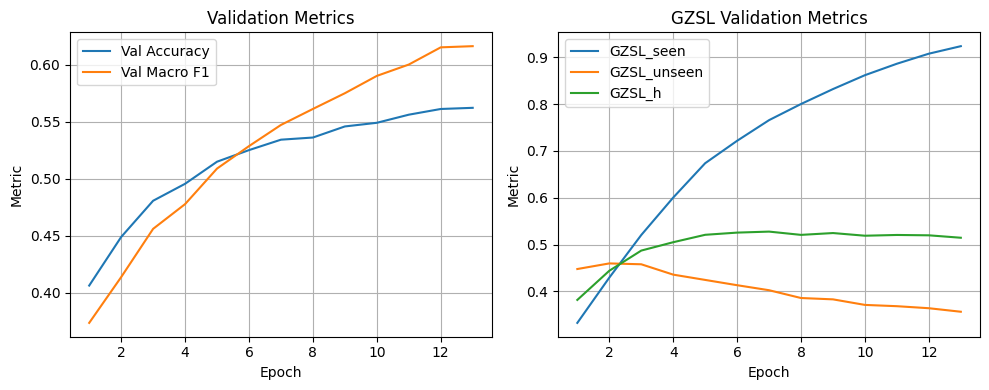

In [35]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.plot(epochs, train_losses, label='Train Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Train Loss')
# plt.grid()
# plt.legend()

plt.subplot(1,2,1)
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.plot(epochs, val_f1s, label='Val Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Validation Metrics')
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, gzsl_seen_accs, label='GZSL_seen')
plt.plot(epochs, gzsl_unseen_accs, label='GZSL_unseen')
plt.plot(epochs, gzsl_hmeans, label='GZSL_h')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('GZSL Validation Metrics')
plt.grid()
plt.legend()



plt.tight_layout()
plt.savefig('metrics_plot.png')
plt.show()

In [24]:
[CUB_200_2011_split Test] Top-1 Accuracy: 0.6512, Macro F1: 0.6285
[CUB_200_2011_split GZSL] Seen acc: 0.0000 | Unseen acc: 0.6512 | H-mean: 0.0000
[dtd_split Test] Top-1 Accuracy: 0.5417, Macro F1: 0.5256
[dtd_split GZSL] Seen acc: 0.0000 | Unseen acc: 0.5417 | H-mean: 0.0000
[fungi_clef_2022_split Test] Top-1 Accuracy: 0.1483, Macro F1: 0.1289
[fungi_clef_2022_split GZSL] Seen acc: 0.0000 | Unseen acc: 0.1483 | H-mean: 0.0000

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine